In [4]:
import pickle
import os
from itertools import combinations_with_replacement

import torch
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from skimage.restoration import wiener
import numpy as np
from tqdm.notebook import tqdm
import japanize_matplotlib

from data.blur_funcs import FUNCS_GR, ACTIONS_GR, ACTIONS_GR2, FUNCS_RN, kernel1, kernel2, kernel4, dilig, blur

SEED = 0
SAMPLE_SIZE = 1000
TEST_SIZE = 10000

In [2]:
def apply(original_set, train_funcs, c):  
    dataset = []
    for k, func in enumerate(train_funcs):
        img = original_set[k]
        det_img = img.copy()
        det_img = func(det_img, c=c)
        dataset.append(det_img)
    return np.array(dataset)


def pure_apply(Dx, funcs):
    Dy = []
    for n, func in enumerate(g345_funcs):
        xn = Dx[n].copy()
        yn = func(xn)
        Dy.append(yn)
    return np.array(Dy)


# def augument_data(source):
#     data = []
#     for c in source:
#         new = [
#             c,
#             np.rot90(c, np.random.randint(1, 4)),
#             np.fliplr(c),
#             np.flipud(c)                
#         ]
#         data.extend(new)
#     data = np.array(data, dtype=source.dtype)
#     return data


def create_train_dataset(train_funcs, c=3, fname='', seed=SEED, size=SAMPLE_SIZE):
    train_dataset = datasets.MNIST(root='../open_data/', train=True, download=True)
    np.random.seed(seed)
    idx = np.random.choice(train_dataset.data.shape[0], size)
    imgs = train_dataset.data[idx].numpy()
#     augumented_dataset = augument_data(imgs)
    originals = imgs
    originals = originals / 255

    train_dataset = apply(originals, train_funcs, c)

    np.savez(
        os.path.join('data', fname),
        train_dataset=train_dataset,
        original_dataset=originals,
    )
    

def create_test_dataset(funcs, fname='', c=3):
    originals = datasets.MNIST(root='../open_data/', train=False, download=True).data.numpy()
    originals = originals / 255    
    
    test_dataset = apply(originals, funcs, c)
    np.savez(
        os.path.join('data', fname),
        test_dataset=test_dataset,
        original_dataset=originals,
    )

In [4]:
# (Train Data)
# 分散9のversion
TYPE = 'GR3.0'
os.makedirs('data/%s' % TYPE, exist_ok=True)
C = 3
funcs_gauss = [FUNCS_GR[0]] * SAMPLE_SIZE
# Gaussだけ, C=3
create_train_dataset(funcs_gauss, c=C, fname='%s/train_gauss_dataset.npz' % TYPE)

In [5]:
# ランダムフィルタも含めた訓練データを作成
# with random
funcs_with_random = funcs_gauss[:SAMPLE_SIZE//2] + [FUNCS_GR[1]] * (SAMPLE_SIZE//2)
print(len(funcs_with_random))
create_train_dataset(funcs_with_random, c=C, fname='%s/train_with_random_dataset.npz' % TYPE)

# random
# with random
funcs_random = [FUNCS_GR[1]] * SAMPLE_SIZE
create_train_dataset(funcs_random, c=C, fname='%s/train_random_dataset.npz' % TYPE)

1000


In [50]:
# (Train Data)
# kernel4とgaussの混合データ
TYPE = 'GR'
os.makedirs('data/%s' % TYPE, exist_ok=True)
funcs_with_kernel4 = funcs_gauss[:SAMPLE_SIZE//2] + [FUNCS_RN[3]] * (SAMPLE_SIZE//2)
create_train_dataset(funcs_with_kernel4, c=3, fname='%s/train_with_kernel4_dataset.npz' % TYPE)

In [6]:
# (Test Data)
action_types = 'GR'
os.makedirs(f'data/{action_types}/test', exist_ok=True)
os.makedirs(f'data/{action_types}/test/gauss', exist_ok=True)
os.makedirs(f'data/{action_types}/test/random', exist_ok=True)
os.makedirs(f'data/{action_types}/test/smooth', exist_ok=True)

for C in range(1, 6):
    # gauss
    funcs_gauss = [FUNCS_GR[0]] * TEST_SIZE
    create_test_dataset(funcs_gauss, c=C, fname=f'{action_types}/test/gauss/c{C}_dataset.npz')

    # random
    funcs_random = [FUNCS_GR[1]] * TEST_SIZE
    create_test_dataset(funcs_random, c=C, fname=f'{action_types}/test/random/c{C}_dataset.npz')

    # # smooth
    kernel3 = np.ones_like(kernel1)
    kernel3 = kernel3 / kernel3.sum()
    f = dilig(lambda x, c=3: blur(x, kernel3, c))
    funcs_smooth = [f] * TEST_SIZE
    create_test_dataset(funcs_smooth, c=C, fname=f'{action_types}/test/smooth/c{C}_dataset.npz')

In [11]:
C = 5
funcs_random = [FUNCS_GR[1]] * TEST_SIZE
create_test_dataset(funcs_random, c=C, fname='GR' + f'/test/random/c{C}_dataset.npz')

In [54]:
# (Test Data)
# kernel4
os.makedirs('data/GR/test/kernel4', exist_ok=True)
for C in range(1, 6):
    funcs_kernel4 = [FUNCS_RN[3]] * TEST_SIZE
    create_test_dataset(funcs_kernel4, c=C, fname='GR' + f'/test/kernel4/c{C}_dataset.npz')

In [31]:
# 分散3のversion
TYPE = 'GR1.6'
os.makedirs('data/%s' % TYPE, exist_ok=True)
C = 3
funcs_gauss = [FUNCS_GR[0]] * SAMPLE_SIZE
# Gaussだけ, C=3
create_train_dataset(funcs_gauss, c=C, fname='%s/train_gauss_dataset.npz' % TYPE)

# with random
funcs_with_random = funcs_gauss[:SAMPLE_SIZE//2] + [FUNCS_GR[1]] * (SAMPLE_SIZE//2)
create_train_dataset(funcs_with_random, c=C, fname='%s/train_with_random_dataset.npz' % TYPE)

# random
# with random
funcs_random = [FUNCS_GR[1]] * SAMPLE_SIZE
create_train_dataset(funcs_random, c=C, fname='%s/train_random_dataset.npz' % TYPE)

In [25]:
## ガウス x3, x4, x5を混ぜた訓練データを作成
# gaussc345_train_dataset.npz
os.makedirs('data/GR', exist_ok=True)
# C = 3
f3 = dilig(lambda x, c=3: blur(x, kernel1, c))
f4 = dilig(lambda x, c=4: blur(x, kernel1, c))
f5 = dilig(lambda x, c=5: blur(x, kernel1, c))

g345_funcs = [f3]*340 + [f4]*330 + [f5]*330

Dx = datasets.MNIST(root='../open_data/', train=True, download=True)
np.random.seed(0)
idx = np.random.choice(Dx.data.shape[0], SAMPLE_SIZE)
Dx = Dx.data[idx].numpy() / 255
Dy = pure_apply(Dx.copy(), g345_funcs)

np.savez(
    os.path.join('data/GR/c345_train_dataset.npz'),
    train_dataset=Dy,
    original_dataset=Dx,
)

In [28]:
## ガウス x3,x5, random x3,x5を混ぜた訓練データを作成
# gaussc345_train_dataset.npz
os.makedirs('data/GR', exist_ok=True)
# C = 3
fg3 = dilig(lambda x, c=3: blur(x, kernel1, c))
fg5 = dilig(lambda x, c=5: blur(x, kernel1, c))
fr3 = dilig(lambda x, c=3: blur(x, kernel2, c))
fr5 = dilig(lambda x, c=5: blur(x, kernel2, c))

gr35_funcs = [fg3]*250 + [fg5]*250 + [fr3]*250 + [fr5]*250

Dx = datasets.MNIST(root='../open_data/', train=True, download=True)
np.random.seed(0)
idx = np.random.choice(Dx.data.shape[0], SAMPLE_SIZE)
Dx = Dx.data[idx].numpy() / 255
Dy = pure_apply(Dx.copy(), gr35_funcs)

np.savez(
    os.path.join('data/GR/gr35_train_dataset.npz'),
    train_dataset=Dy,
    original_dataset=Dx,
)

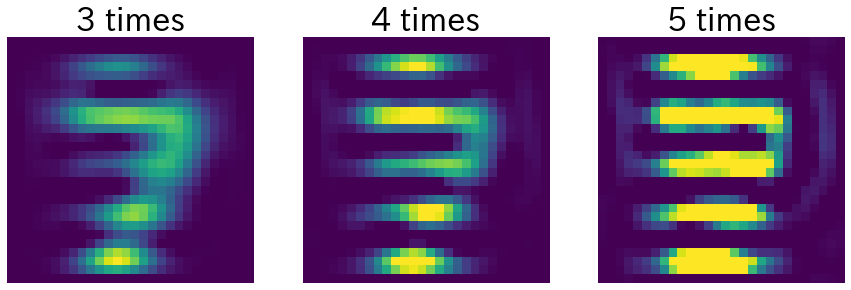

In [6]:
train_context = np.load('data/GR/test/gauss/c5_dataset.npz')
Dy = train_context['test_dataset']
Dx = train_context['original_dataset']


# ガウスで3回やったやつはガウスでも戻らんかい
n = 0
x = Dx[n]
y = Dy[n]
fs = 32

plt.figure(figsize=(15, 8))    
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('3 times', fontsize=fs)
y1 = y.copy()
for j in range(3):
    y1 = ACTIONS_GR[2](y1)
plt.imshow(y1)

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title(f'4 times', fontsize=fs)
y2 = y.copy()
for j in range(4):
    y2 = ACTIONS_GR[2](y2)
plt.imshow(y2)
plt.imshow(y2)

    
plt.subplot(1, 3, 3)
plt.title(f'5 times', fontsize=fs)
y3 = y.copy()
for j in range(5):
    y3 = ACTIONS_GR[2](y3)
plt.axis('off')
plt.imshow(y3)
plt.show()

(array([ 20.,  93.,  90., 175., 176., 178., 152.,  80.,  29.,   7.]),
 array([0.01948563, 0.02507823, 0.03067083, 0.03626343, 0.04185604, 0.04744864, 0.05304124,
        0.05863384, 0.06422644, 0.06981904, 0.07541165]),
 <BarContainer object of 10 artists>)

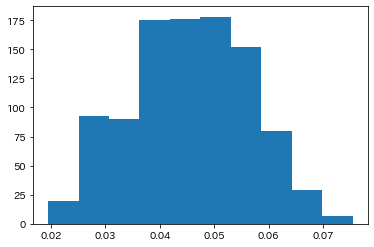

In [9]:
# データをロード
context = np.load('data/GR/train_gauss_dataset.npz')
Dx = context['original_dataset']
Dy_gauss = context['train_dataset']

context = np.load('data/GR/train_random_dataset.npz')
Dy_random = context['train_dataset']

plt.hist(np.mean((Dy_gauss - Dx)**2, axis=(1, 2)))

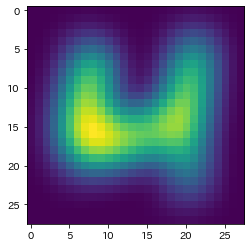


(1000, 2, 6)
gauss [0.03835274 0.04778339 0.17815909] [0.04271115 0.09918933 0.4518628 ]
random [0.0394282  0.04901144 0.17802736] [0.04375443 0.09884259 0.45052527]


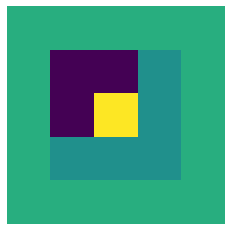

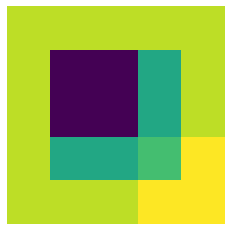

In [11]:
# kernel3, kernel4の性質を確認
context = np.load('data/GR/train_gauss_dataset.npz')
Dx = context['original_dataset']
Dy_gauss = context['train_dataset']

context = np.load('data/GR/train_random_dataset.npz')
Dy_random = context['train_dataset']

plt.imshow(Dy_random[0])
plt.show()
a = np.ones(kernel1.shape)
a[1:4, 1:4] = 0

kernel3 = np.ones(kernel1.shape)
kernel3[1:3, 1:3] = -3
kernel3[2, 2] = 5
kernel3 = kernel3 + a
kernel3 = kernel3 / kernel3.sum()
fig = plt.figure()
plt.imshow(kernel3)
plt.axis('off')
plt.savefig('kernel3.png')

kernel4 = np.ones(kernel1.shape)
kernel4[3:5, 3:5] = 2
kernel4[1:3, 1:3] = -5
kernel4 = kernel4 + 3 * a
kernel4 = kernel4 / kernel4.sum()
fig = plt.figure()
plt.imshow(kernel4)
plt.axis('off')
plt.savefig('data/kernel4.png')

# ガウスフィルタで劣化させた画像と乱数フィルタで劣化させた画像のそれぞれに対して
# kernel3, kernel4でDeconvolutionした際に復元されないことを確認
mse = [] #1000 x 2 x 6
for n in tqdm(range(Dx.shape[0])):
    xn = Dx[n]
    yn_gauss = Dy_gauss[n].copy()
    yn_random = Dy_random[n].copy()
    mse_kernel = []
    for i, kernel in enumerate([kernel3, kernel4], start=1):
        mse_c_gauss = []
        mse_c_random = []
        for c in range(1, 4):
            x_hat_gauss = yn_gauss.copy()
            x_hat_random = yn_random.copy()
            for _ in range(c):
                x_hat_gauss = wiener(x_hat_gauss, kernel, 1e-2)
                x_hat_random = wiener(x_hat_random, kernel, 1e-2)
            mse_c_gauss.append(np.mean((x_hat_gauss - xn)**2))
            mse_c_random.append(np.mean((x_hat_random - xn)**2))
        mse_kernel.append(mse_c_gauss + mse_c_random)
    mse.append(mse_kernel)
mse = np.array(mse)
print(mse.shape)
mse_gauss = mse[:, :, 0:3]
mse_random = mse[:, :, 3:6]
print('gauss', mse_gauss[:, 0, :].mean(axis=0), mse_gauss[:, 1].mean(axis=0))
print('random', mse_random[:, 0, :].mean(axis=0), mse_random[:, 1].mean(axis=0))

##### 作成したデータの確認

In [4]:
# kernel4の訓練データの確認
train_context = np.load(f'data/GR/train_with_kernel4_dataset.npz')
Dy = train_context['train_dataset'][500:]
Dx = train_context['original_dataset'][500:]

mse = []
for n in range(Dy.shape[0]):
    yn = Dy[n]
    xn = Dx[n]
    for _ in range(3):
        yn = wiener(yn, kernel4, 1e-1)
#         yn = ACTIONS_GR2[3](yn)
    mse.append(
        np.mean((yn - xn)**2)
    )
mse = np.array(mse)
mse.mean()

0.036848348623328045

In [33]:
# kernel4の訓練データの確認
train_context = np.load(f'data/GR3.0/test/random/c3_dataset.npz')
Dy = train_context['test_dataset']
Dx = train_context['original_dataset']

mse_init = []
mse_gauss = []
mse_random = []

for n in range(Dy.shape[0]):
    yn = Dy[n]
    xn = Dx[n]
    mse_init.append(np.mean((yn - xn)**2))
    
    yn = Dy[n].copy()
    for _ in range(3):
        yn = ACTIONS_GR[2](yn)
    mse_gauss.append(
        np.mean((yn - xn)**2)
    )
    
    yn = Dy[n].copy()
    for _ in range(3):
        yn = ACTIONS_GR[3](yn)
    mse_random.append(
            np.mean((yn - xn)**2)
    )
mse_init = np.array(mse_init)
mse_gauss = np.array(mse_gauss)
mse_random = np.array(mse_random)

print('c = 3')
print('init', mse_init.mean())
print('gauss', mse_gauss.mean())
print('random', mse_random.mean())

c = 3
init 0.04602599343577285
gauss 0.021127689827861718
random 0.01962356102239557


In [5]:
# kernel4のテストデータの確認
c = 3
train_context = np.load(f'data/GR3.0/test/gauss/c{c}_dataset.npz')
Dy = train_context['test_dataset']
Dx = train_context['original_dataset']

init_mse = []
min_mses = []
min_funcses = []

def optimal_restore(yn, xn, actions):
    min_mse = 100
    min_funcs = None
    for c in range(1, 6):
        for funcs_idx in combinations_with_replacement(range(2, 4), c):
            yn = yn.copy()
            for func_idx in funcs_idx:
                yn = actions[func_idx](yn)
            mse = np.mean((yn - xn)**2)
            if mse < min_mse:
                min_mse = mse
                min_funcs = funcs_idx
    return min_mse, min_funcs
    
actions = ACTIONS_GR # lambda x: xは入れない。
for n in tqdm(range(Dy.shape[0])):
    yn = Dy[n].copy()
    xn = Dx[n]
    init_mse.append(np.mean((yn - xn)**2))
    
    min_mse, min_funcs = optimal_restore(yn, xn, actions)
    min_mses.append(min_mse)
    min_funcses.append(min_funcs)
    
init_mse = np.array(init_mse)
min_mses = np.array(min_mses)
min_funcses = np.array(min_funcses)

print('c =', c)
print('init', init_mse.mean())
print('min mse', min_mses.mean())


c = 3
init 0.041754009905595794
min mse 0.015270243483420412


/home/kato/anaconda3/envs/work/lib/python3.6/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [31]:
# kernel4のテストデータの確認
c = 3
train_context = np.load(f'data/GR3.0/test/random/c{c}_dataset.npz')
Dy = train_context['test_dataset']
Dx = train_context['original_dataset']

init_mse = []
min_mses = []
min_funcses = []
for n in tqdm(range(Dy.shape[0])):
    yn = Dy[n].copy()
    xn = Dx[n]
    init_mse.append(np.mean((yn - xn)**2))
    
    min_mse = 100
    min_funcs = None
    for c in range(1, 6):
        for funcs_idx in combinations_with_replacement(range(2, 4), c):
            yn = Dy[n].copy()
            for func_idx in funcs_idx:
                yn = ACTIONS_GR[func_idx](yn)
            mse = np.mean((yn - xn)**2)
            if mse < min_mse:
                min_mse = mse
                min_funcs = funcs_idx
    min_mses.append(min_mse)
    min_funcses.append(min_funcs)

init_mse = np.array(init_mse)
min_mses = np.array(min_mses)
min_funcses = np.array(min_funcses)

print('c =', c)
print('init', init_mse.mean())
print('min mse', min_mses.mean())


c = 5
init 0.04602599343577285
min mse 0.019102515623608214


/home/kato/anaconda3/envs/work/lib/python3.6/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [32]:
# kernel4のテストデータの確認
c = 3
train_context = np.load(f'data/GR3.0/test/smooth/c{c}_dataset.npz')
Dy = train_context['test_dataset']
Dx = train_context['original_dataset']

init_mse = []
min_mses = []
min_funcses = []
for n in tqdm(range(Dy.shape[0])):
    yn = Dy[n].copy()
    xn = Dx[n]
    init_mse.append(np.mean((yn - xn)**2))
    
    min_mse = 100
    min_funcs = None
    for c in range(1, 6):
        for funcs_idx in combinations_with_replacement(range(2, 4), c):
            yn = Dy[n].copy()
            for func_idx in funcs_idx:
                yn = ACTIONS_GR[func_idx](yn)
            mse = np.mean((yn - xn)**2)
            if mse < min_mse:
                min_mse = mse
                min_funcs = funcs_idx
    min_mses.append(min_mse)
    min_funcses.append(min_funcs)

init_mse = np.array(init_mse)
min_mses = np.array(min_mses)
min_funcses = np.array(min_funcses)

print('c =', c)
print('init', init_mse.mean())
print('min mse', min_mses.mean())


c = 5
init 0.04728199786482049
min mse 0.021758543998177997


/home/kato/anaconda3/envs/work/lib/python3.6/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [30]:
print(min_funcses[0])
for j in range(5):
    plt.hist(min_funcses[:, j], bins=np.arange(5) - 0.5)
    plt.show()

(2, 2)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [5]:
from data.blur_funcs import kernel2, kernel4, ACTIONS_GR2
# kernel4のテストデータの確認
for c in range(1, 6):
    train_context = np.load(f'data/GR/test/kernel4/c{c}_dataset.npz')
    Dy = train_context['test_dataset']
    Dx = train_context['original_dataset']
    
    init_mse = []
    mse = []
    for n in range(Dy.shape[0]):
        yn = Dy[n]
        xn = Dx[n]
        init_mse.append(np.mean((yn - xn)**2))
        for _ in range(c):
            yn = ACTIONS_GR2[3](yn)
        mse.append(
            np.mean((yn - xn)**2)
        )
    init_mse = np.array(init_mse)
    mse = np.array(mse)
    print(c, mse.mean(), init_mse.mean())

1 0.011772974449663597 0.07074865559441797
2 0.021298104116474308 0.052705566097818964
3 0.03381127844650704 0.06552325547488658
4 0.0590611399014771 0.06791535869047657
5 0.10714441125966623 0.07027636312957457


In [28]:
train_context = np.load('data/GR/train_kernel3_dataset.npz')
Dy = train_context['train_dataset']
Dx = train_context['original_dataset']

mse = []
for n in range(Dy.shape[0]):
    yn = Dy[n]
    xn = Dx[n]
    for _ in range(3):
        yn = wiener(yn, kernel3, 1e-1)
    mse.append(
        np.mean((yn - xn)**2)
    )
mse = np.array(mse)
mse.mean()

0.030817874839344284

In [2]:
kernel4_file = kernel4

In [3]:
print(kernel4_file.shape)
print(kernel4_file)

a = np.ones(kernel1.shape)
a[1:4, 1:4] = 0
kernel4 = np.ones(kernel1.shape)
kernel4[3:5, 3:5] = 2
kernel4[1:3, 1:3] = -5
kernel4 = kernel4 + 3 * a
kernel4 = kernel4 / kernel4.sum()
print(kernel4.shape)
print(kernel4)

np.allclose(kernel4_file, kernel4)

(5, 5)
[[ 0.0754717   0.0754717   0.0754717   0.0754717   0.0754717 ]
 [ 0.0754717  -0.09433962 -0.09433962  0.01886792  0.0754717 ]
 [ 0.0754717  -0.09433962 -0.09433962  0.01886792  0.0754717 ]
 [ 0.0754717   0.01886792  0.01886792  0.03773585  0.09433962]
 [ 0.0754717   0.0754717   0.0754717   0.09433962  0.09433962]]
(5, 5)
[[ 0.0754717   0.0754717   0.0754717   0.0754717   0.0754717 ]
 [ 0.0754717  -0.09433962 -0.09433962  0.01886792  0.0754717 ]
 [ 0.0754717  -0.09433962 -0.09433962  0.01886792  0.0754717 ]
 [ 0.0754717   0.01886792  0.01886792  0.03773585  0.09433962]
 [ 0.0754717   0.0754717   0.0754717   0.09433962  0.09433962]]


True

0.05859360621963805


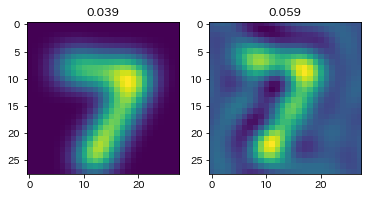

0.029436324049012648


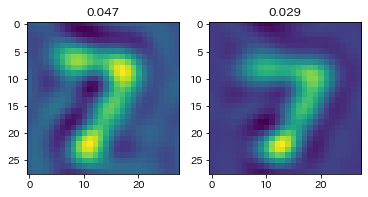

In [19]:
from skimage.restoration import wiener
from data.blur_funcs import ACTIONS_RN, kernel3

train_context = np.load('data/GR/test/gauss/c3_dataset.npz')
Dy = train_context['test_dataset']
Dx = train_context['original_dataset']

yn = Dy[0]
xn = Dx[0]

# gauss blurred img
plt.subplot(121)
plt.title('%.3lf' % np.mean((yn - xn)**2))
plt.imshow(yn)

for _ in range(3):
    yn = wiener(yn, kernel3, 1e-1)
    
print(np.mean((yn - xn)**2))
plt.subplot(122)
plt.title('%.3lf' % np.mean((yn - xn)**2))
plt.imshow(yn)
plt.show()

# kernel3 blurred img
yn2 = blur(xn.copy(), kernel3, c=3)
plt.subplot(121)
plt.title('%.3lf' % np.mean((yn2 - xn)**2))
plt.imshow(yn)

for _ in range(3):
    yn2 = wiener(yn2, kernel3, 1e-1)
    
print(np.mean((yn2 - xn)**2))
plt.subplot(122)
plt.title('%.3lf' % np.mean((yn2 - xn)**2))
plt.imshow(yn2)
plt.show()

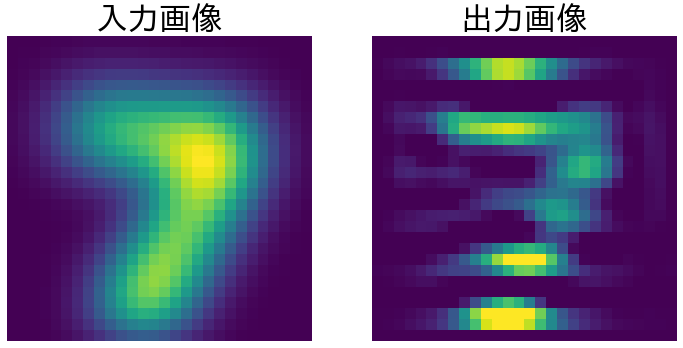

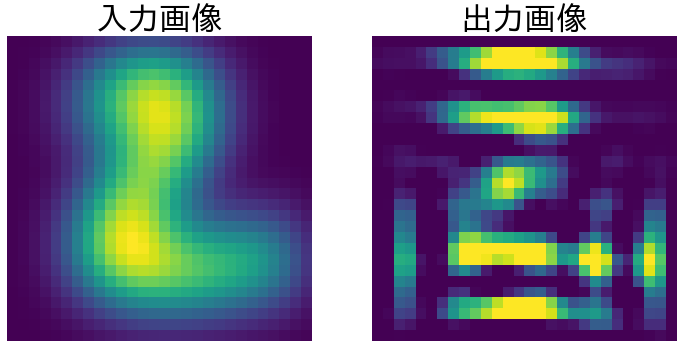

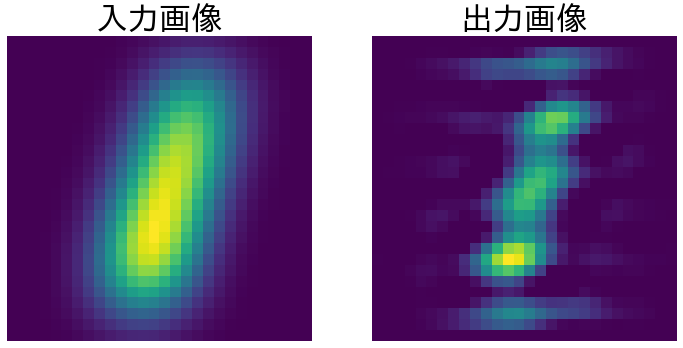

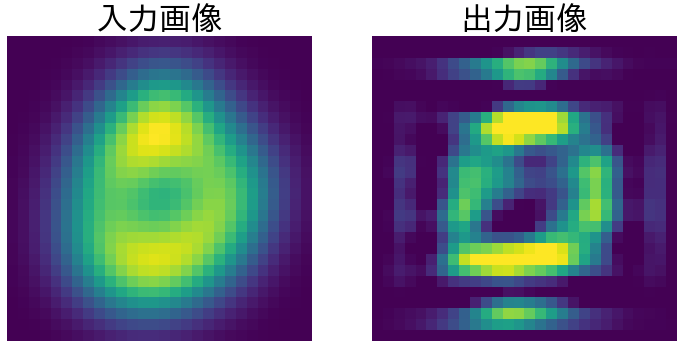

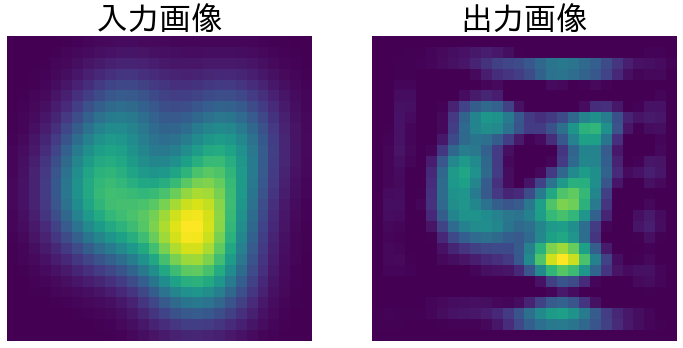

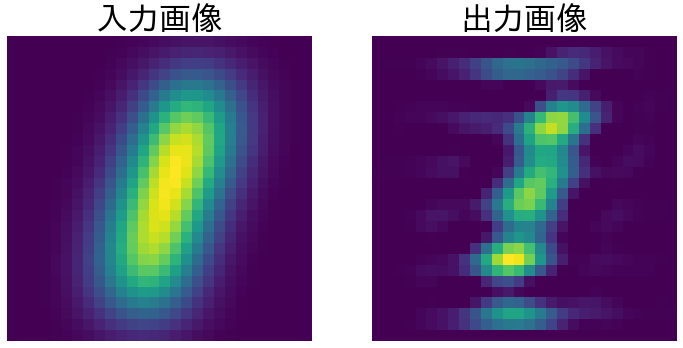

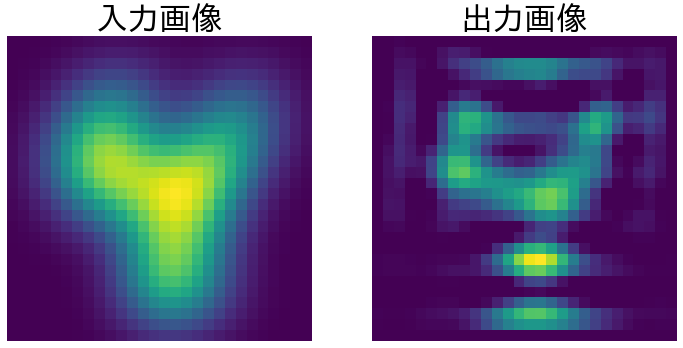

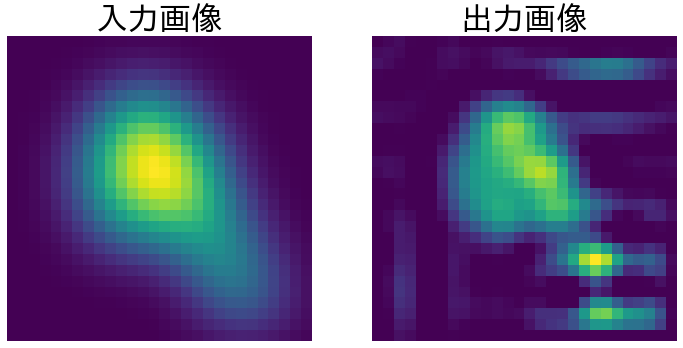

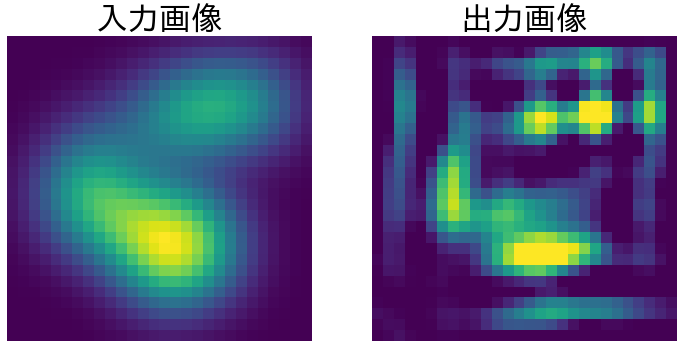

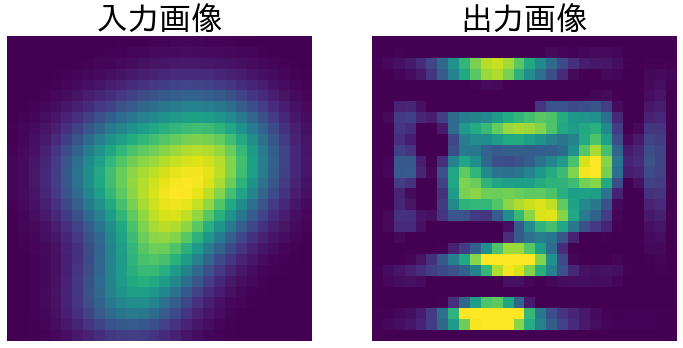

In [22]:
train_context = np.load('data/GR/test/gauss/c5_dataset.npz')
Dy = train_context['test_dataset']
Dx = train_context['original_dataset']

# ガウスで3回やったやつはガウスでも戻らんかい
for n in range(10):
    x = Dx[n]
    y = Dy[n].copy()
    plt.figure(figsize=(12, 8))    
    plt.subplot(1, 2, 1)
    plt.axis('off')
#     plt.title('y \n%.3lf(MSE)' % np.mean((y - x)**2), fontsize=42)
    plt.title('入力画像' % np.mean((y - x)**2), fontsize=32)
    plt.imshow(y)

    for j in range(5):
        y = ACTIONS_GR[2](y)
        score = np.mean((y - x)**2)
    plt.subplot(1, 2, 2)
    plt.axis('off')
#     plt.title(f'$z_{j+1}$\n%.3lf(MSE)' % score, fontsize=42)
    plt.title(f'出力画像' % score, fontsize=32)
    plt.imshow(y)
    plt.show()
# s / len(train_dataset)

##### 訓練データの確認

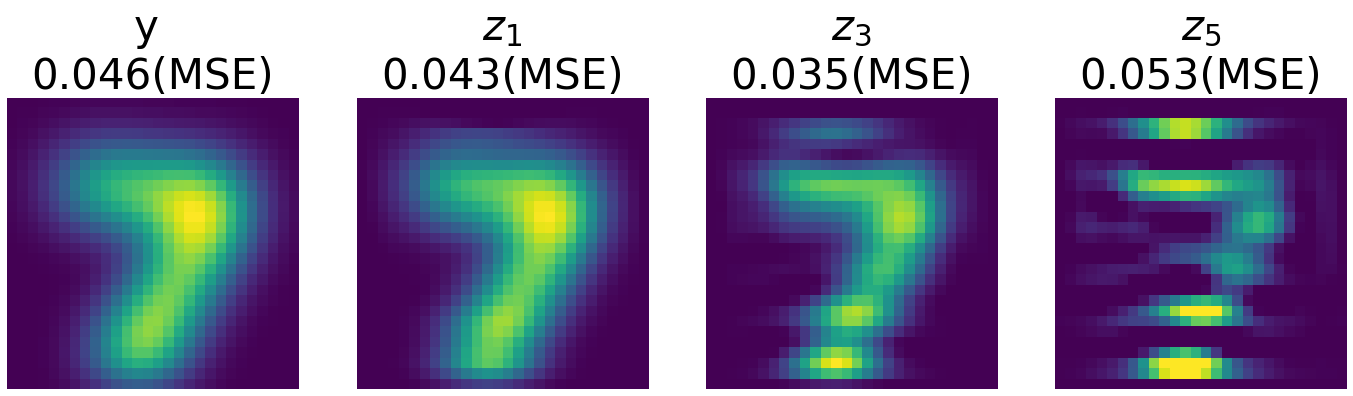

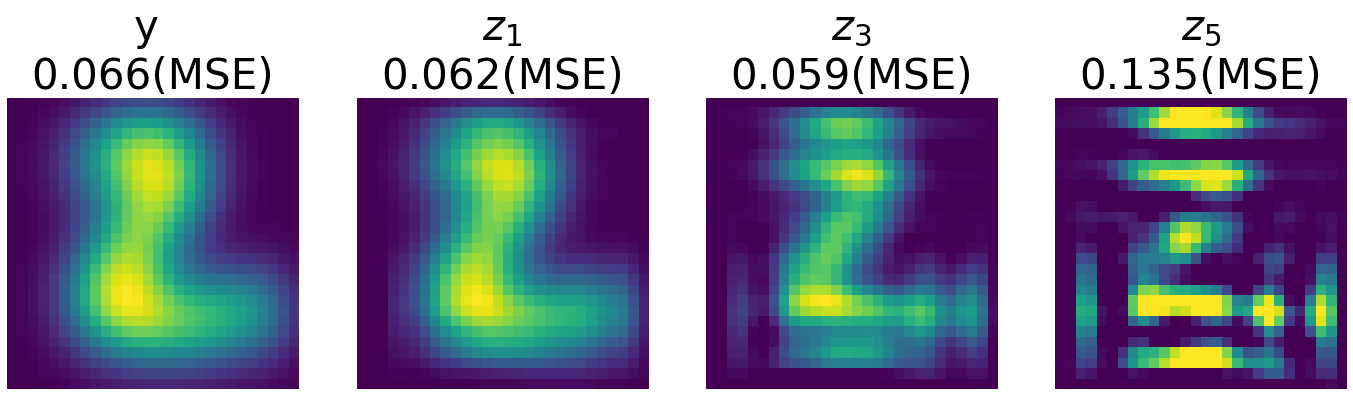

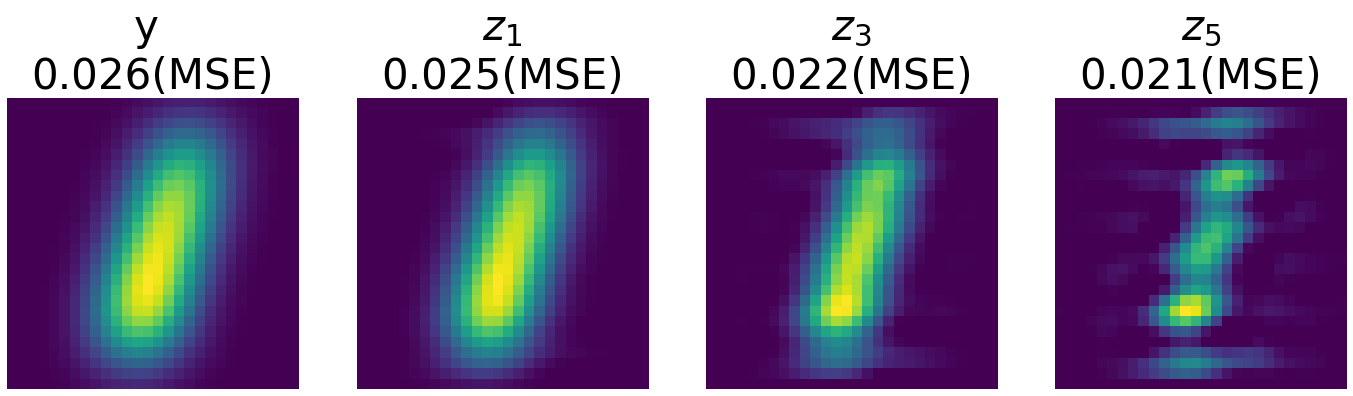

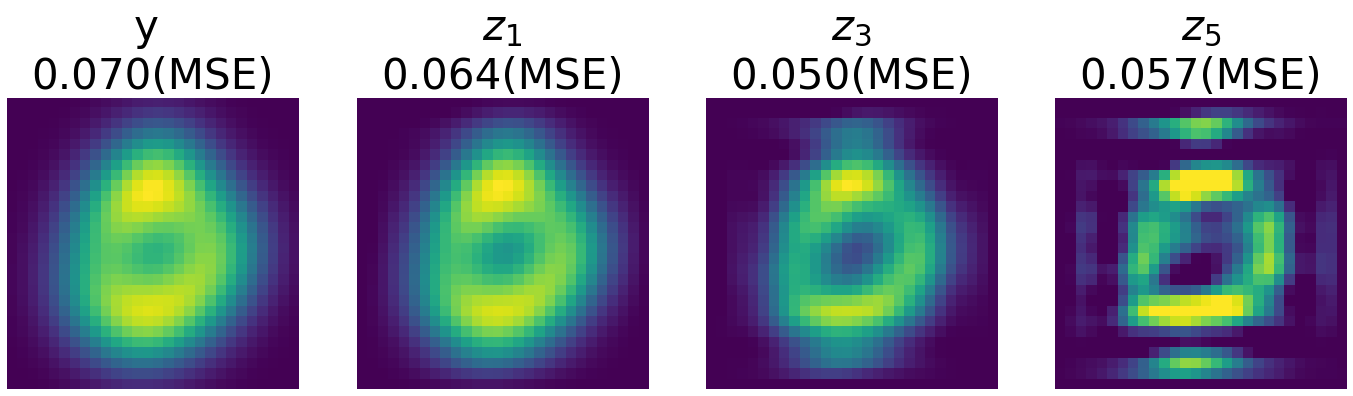

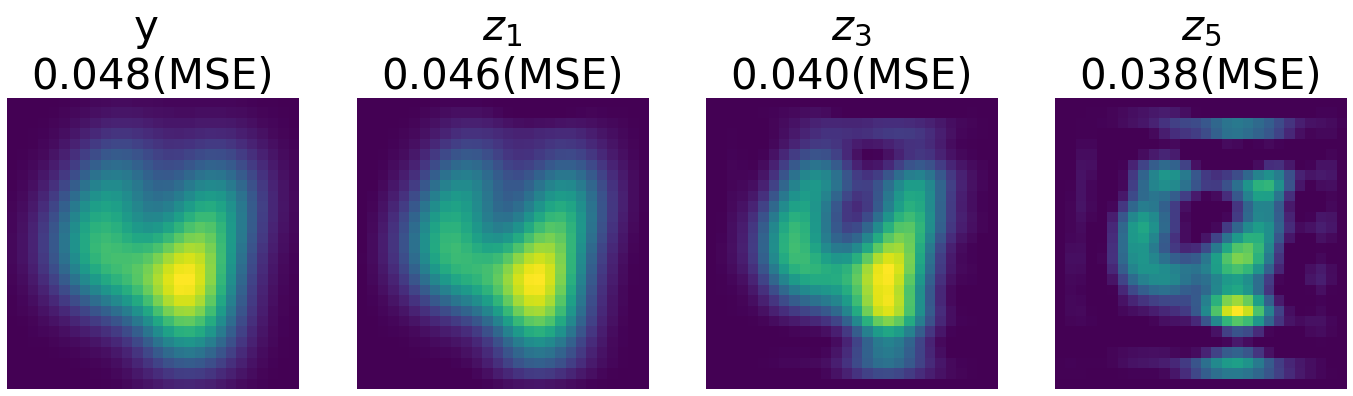

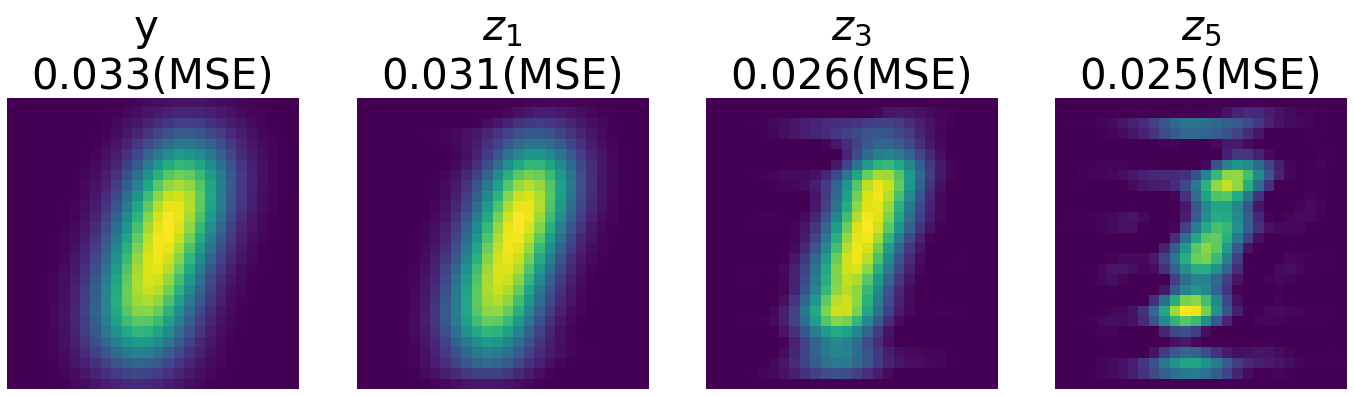

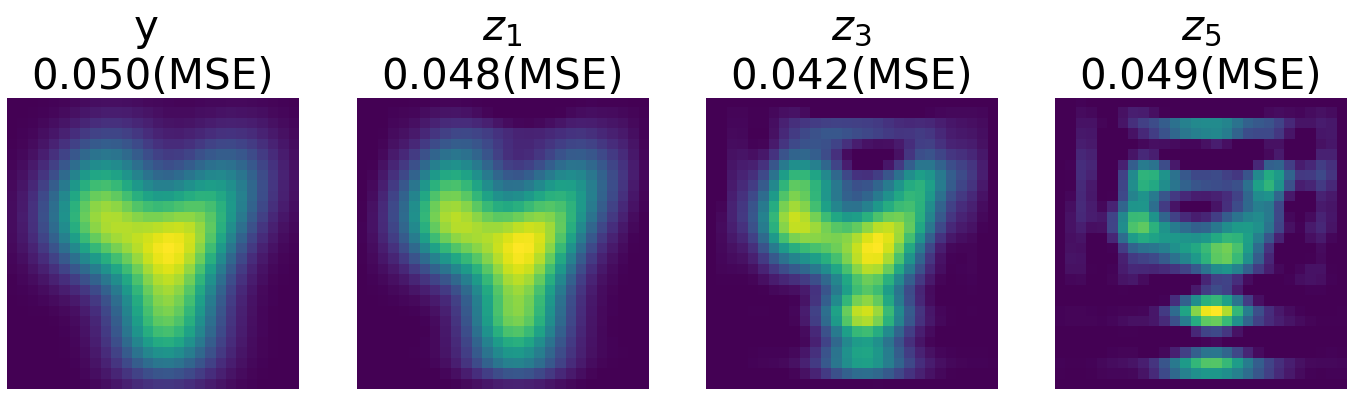

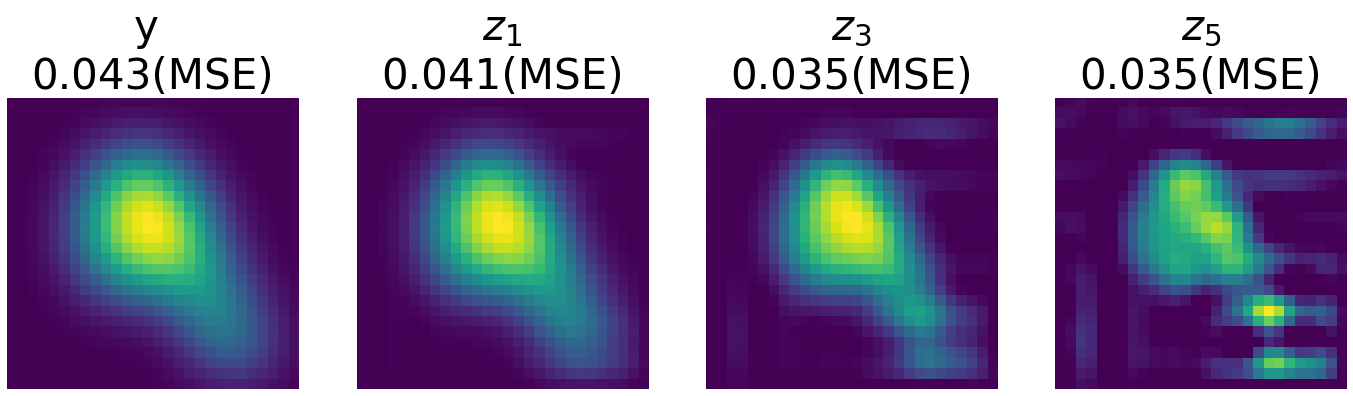

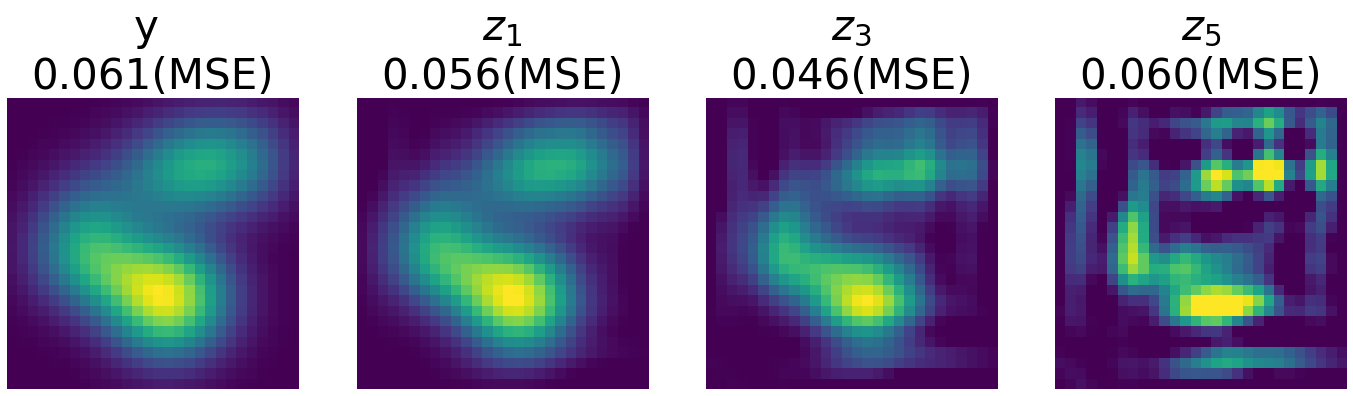

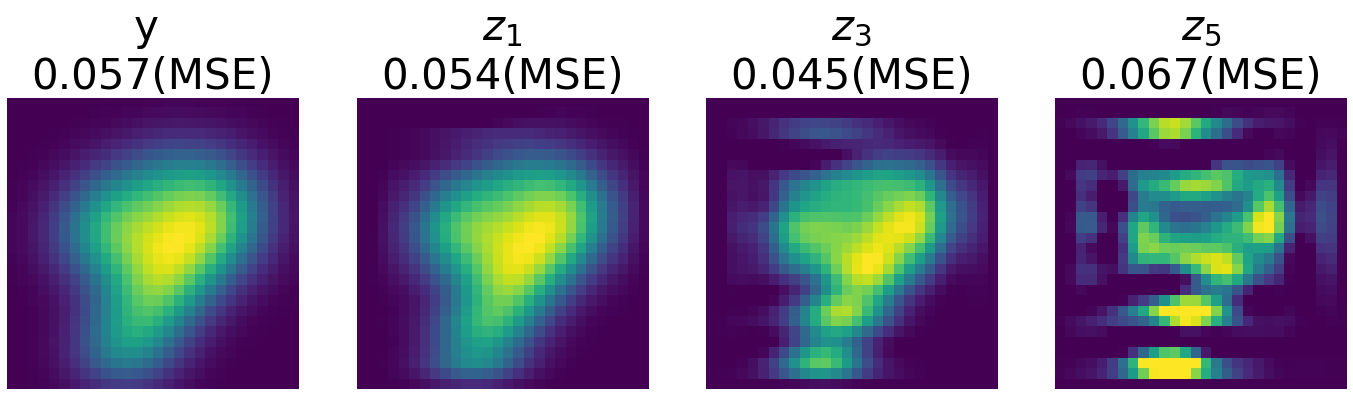

In [15]:
train_context = np.load('data/GR/test/gauss/c5_dataset.npz')
Dy = train_context['test_dataset']
Dx = train_context['original_dataset']


# ガウスで3回やったやつはガウスでも戻らんかい
for n in range(10):
    x = Dx[n]
    y = Dy[n].copy()
    plt.figure(figsize=(24, 10))    
    plt.subplot(1, 4, 1)
    plt.axis('off')
    plt.title('y \n%.3lf(MSE)' % np.mean((y - x)**2), fontsize=42)
    plt.imshow(y)

    for j in range(5):
        y = ACTIONS_GR[2](y)
        score = np.mean((y - x)**2)
        if j in [0, 2, 4]:
            plt.subplot(1, 4, j//2+2)
            plt.axis('off')
            plt.title(f'$z_{j+1}$\n%.3lf(MSE)' % score, fontsize=42)
            plt.imshow(y)
    plt.show()
# s / len(train_dataset)

##### テストデータの確認

In [14]:
filt = 'gauss'
c = 3
TEST_DATASET_PATH = 'data/GR/test/%s/c%d_dataset.npz' % (filt, c)
test_dataset_context = np.load(TEST_DATASET_PATH)
originals = test_dataset_context['original_dataset']
test_dataset = test_dataset_context['test_dataset']
test_dataset = torch.from_numpy(test_dataset)
originals = torch.from_numpy(originals)

In [16]:
# ガウスで3回やったやつはガウスx3で戻る？
s = 0
for t in test_dataset:
    a = t.clone()
    for _ in range(3):
        a = ACTIONS_GR[2](a)
    s += torch.mean((a - t)**2).item()
s / len(test_dataset)

0.01731489976105362

0.041754009905595725
0.01403988877732478


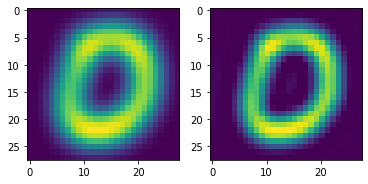

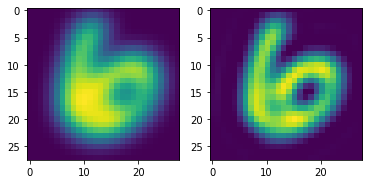

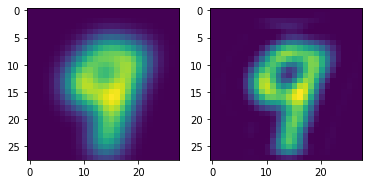

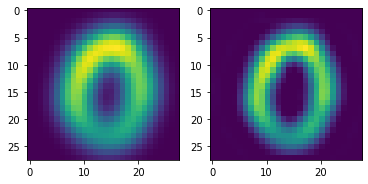

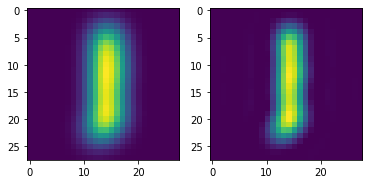

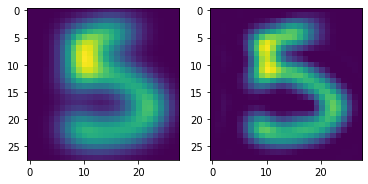

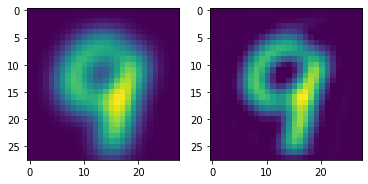

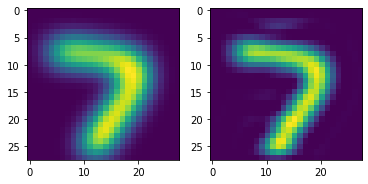

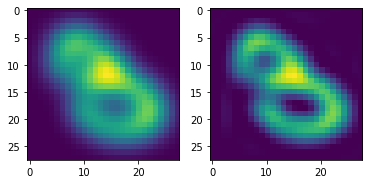

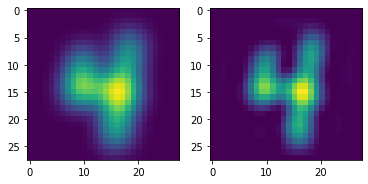

In [17]:
# TRY: MNISTのテストデータからgauss x 3 で作成したデータをgauss weiner x 3で戻る？
originals = datasets.MNIST(root='../open_data/', train=False, download=True).data.numpy()
originals = originals / 255    

# データ作成
data = []
blr_mse = 0
for i in range(originals.shape[0]):
    o = originals[i]
    blr = o.copy()
    for _ in range(3):
        blr = blur(o, kernel1, c=3)
    blr_mse += np.mean((o - blr)**2)
    data.append(blr)
print(blr_mse / originals.shape[0])
data = np.array(data)
data.shape

# テスト評価
test_mse = 0
for i in range(data.shape[0]):
    d = data[i].copy()
    for _ in range(3):
        d = ACTIONS_GR[2](d)
    o = originals[i]
    test_mse += np.mean((d - o)**2)
print(test_mse / data.shape[0])

for i in range(10, 20):
    d = data[i].copy()
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(d)
    for _ in range(2):
        d = ACTIONS_GR[2](d)
    axes[1].imshow(d)
    plt.show()

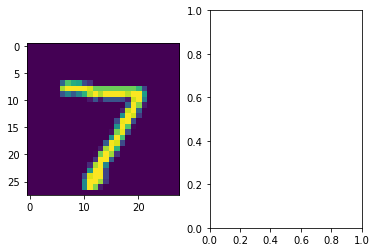

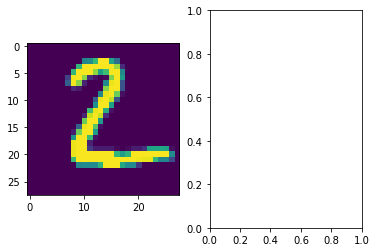

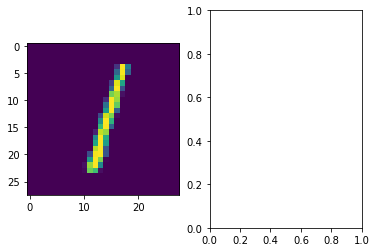

In [37]:
for i in range(3):
    o = originals[i]
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(o)
    plt.show()